Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import gc
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [2]:
# Read in the data sets
X_train = pd.read_csv("data/X_train.csv").set_index('Unnamed: 0')
X_test = pd.read_csv("data/X_test.csv").set_index('Unnamed: 0')
y_train = pd.read_csv("data/y_train.csv").set_index('Unnamed: 0')
y_test = pd.read_csv("data/y_test.csv").set_index('Unnamed: 0')

## Feature Importance Testing

In [27]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()

numeric_features = X_train2.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train2.select_dtypes(include=['object']).columns

num_impute = SimpleImputer(strategy="median")
cat_impute = SimpleImputer(strategy="most_frequent")
scaler = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

X_train2_obj = X_train2[categorical_features]
X_test2_obj = X_test2[categorical_features]

cat_impute.fit(X_train2_obj)
X_train2_imp = cat_impute.transform(X_train2_obj)
X_test2_imp = cat_impute.transform(X_test2_obj)

ohe.fit(X_train2_imp)
X_train_ohe = ohe.transform(X_train2_imp)
X_test_ohe = ohe.transform(X_test2_imp)

In [31]:
X_train2_num = X_train2[numeric_features]
X_test2_num = X_test2[numeric_features]

num_impute.fit(X_train2_num)
X_train2_impnum = num_impute.transform(X_train2_num)
X_test2_impnum = num_impute.transform(X_test2_num)

scaler.fit(X_train2_impnum)
X_train_scaled = scaler.transform(X_train2_impnum)
X_test_scaled = scaler.transform(X_test2_impnum)

In [32]:
X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns = numeric_features,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, 
                             columns = numeric_features,
                             index=X_test.index)

,mother_age,mother_native,mother_hispanic,father_age,living_children,deceased_children,terminations,months_prenatal_care,prenatal_visits,prepregnancy_daily_cig,first_tri_daily_cig,second_tri_daily_cig,third_tri_daily_cig,height,bmi,delivery_weight,weight_gain,previous_cesareans,plural_pregnancy,weeks_gestation
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
1659022,0.526316,1.0,0.0,0.355932,0.071429,0.0,0.000000,0.3,0.10,0.0,0.0,0.0,0.0,0.729167,0.065192,0.120000,0.183673,0.142857,0.0,0.566667
1482674,0.578947,1.0,0.0,0.305085,0.071429,0.0,0.000000,0.3,0.28,0.0,0.0,0.0,0.0,0.833333,0.405122,0.786667,0.000000,0.000000,0.0,0.500000
2671477,0.368421,0.0,1.0,0.305085,0.071429,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.708333,0.057043,0.136667,0.316327,0.142857,0.0,0.333333
1196310,0.447368,1.0,0.0,0.271186,0.000000,0.0,0.166667,0.2,0.30,0.0,0.0,0.0,0.0,0.708333,0.110594,0.226667,0.316327,0.000000,0.0,0.700000
62426,0.552632,1.0,0.0,0.305085,0.000000,0.0,0.111111,0.3,0.36,0.0,0.0,0.0,0.0,0.708333,0.096624,0.123333,0.071429,0.000000,0.0,0.666667


In [28]:
X_train_ohe = pd.DataFrame(X_train_ohe, 
                           columns = ohe.get_feature_names(input_features = categorical_features),
                           index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, 
                          columns = ohe.get_feature_names(input_features = categorical_features),
                          index=X_test.index)

In [33]:
X_train_processed = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_processed = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train_processed.head()

,birth_place_hospital,birth_place_other,mother_race_asian/pi,mother_race_black,mother_race_native_american,mother_race_white,marital_status_married,marital_status_unmarried,mother_education_college_or_higher,mother_education_hs_or_lower,...,first_tri_daily_cig,second_tri_daily_cig,third_tri_daily_cig,height,bmi,delivery_weight,weight_gain,previous_cesareans,plural_pregnancy,weeks_gestation
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1659022,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.729167,0.065192,0.120000,0.183673,0.142857,0.0,0.566667
1482674,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.833333,0.405122,0.786667,0.000000,0.000000,0.0,0.500000
2671477,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.708333,0.057043,0.136667,0.316327,0.142857,0.0,0.333333
1196310,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.708333,0.110594,0.226667,0.316327,0.000000,0.0,0.700000
62426,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.708333,0.096624,0.123333,0.071429,0.000000,0.0,0.666667


In [34]:
# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 100,
                                        criterion ='entropy', max_depth=3, random_state=27)
  
# Training the model
extra_tree_forest.fit(X_train_processed, y_train.values.ravel())
  
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

print(feature_importance)

[0.00000000e+00 1.59236625e-05 2.97769636e-03 1.04474831e-01
 5.90406325e-05 2.24500737e-02 2.13064891e-02 1.97605204e-02
 1.61426684e-02 1.46229076e-02 1.69186349e-04 3.53750942e-05
 3.51288792e-04 9.22827447e-04 6.55179543e-03 1.44715064e-05
 1.73299090e-04 2.66933975e-02 6.41989650e-03 1.17314443e-02
 2.97976924e-02 7.93211702e-04 3.42527631e-04 2.24846830e-03
 6.90358920e-03 1.02992944e-03 1.32907753e-03 0.00000000e+00
 9.62555443e-05 1.91391665e-04 1.10707643e-03 0.00000000e+00
 0.00000000e+00 6.04991351e-05 7.34392223e-05 5.19245995e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.66464334e-05
 1.48237636e-04 1.69234696e-01 1.51342538e-01 5.11270183e-03
 9.49627963e-03 3.98717531e-02 3.42250839e-02 1.56354550e-03
 1.38266010e-03 1.70093604e-05 0.00000000e+00 3.69239672e-04
 4.09159003e-03 1.26839809e-02 4.37228548e-05 2.04494795e-03
 1.25355170e-03 2.45630420e-04 2.23602324e-03 3.31576783e-02
 1.31644187e-04 3.36028625e-04 5.17734836e-05 1.06550253e-04
 2.95178367e-04 6.851136

In [39]:
feature_importance_normalized

array([0.00000000e+00, 1.58438442e-04, 1.92477576e-02, 1.72350265e-01,
       4.47014814e-04, 6.86286070e-02, 6.05472550e-02, 7.46969851e-02,
       5.23611152e-02, 5.10153634e-02, 1.09354096e-03, 3.51977743e-04,
       2.15636972e-03, 6.51899385e-03, 2.52329494e-02, 1.20303389e-04,
       1.72430418e-03, 6.39224283e-02, 2.34764607e-02, 3.95245485e-02,
       7.62196577e-02, 4.15394070e-03, 2.87364421e-03, 1.25872046e-02,
       2.70271417e-02, 6.07543497e-03, 8.18966664e-03, 0.00000000e+00,
       7.43411390e-04, 1.13487166e-03, 7.02803879e-03, 0.00000000e+00,
       0.00000000e+00, 6.01958794e-04, 7.30711036e-04, 5.16643242e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.65128665e-04,
       1.11592261e-03, 2.86902092e-01, 2.62948965e-01, 2.95801042e-02,
       3.51119968e-02, 8.66201142e-02, 7.57163568e-02, 6.36159010e-03,
       5.49700239e-03, 1.34594995e-04, 0.00000000e+00, 1.70515711e-03,
       2.15501629e-02, 3.50163997e-02, 4.35036913e-04, 1.32398108e-02,
      

In [52]:
ext = pd.DataFrame(list(feature_importance_normalized), index=list(X_train_processed.columns))
# ext
ext_sorted = ext.sort_values(by=0, ascending=False)
ext_sorted[:20]

,0
weeks_gestation,0.327550
steroids_N,0.286902
steroids_Y,0.262949
mother_race_black,0.172350
prenatal_visits,0.124557
chorioamnionitis_N,0.086620
plural_pregnancy,0.083213
gestational_hypertension_Y,0.076220
chorioamnionitis_Y,0.075716
marital_status_unmarried,0.074697


In [3]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [4]:
preproc = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

X_train_proc = preproc.fit_transform(X_train)
X_test_proc = preproc.transform(X_test)

In [15]:
X_train_proc.shape

(20000, 71)

In [6]:
X_train.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
       'down_syndrome'],
      dtype='object')

## Test Feature Selection

In [10]:
# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 100,
                                        criterion ='entropy', max_depth=3, random_state=27)
  
# Training the model
extra_tree_forest.fit(X_train_proc, y_train.values.ravel())
  
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

print(feature_importance)

[3.47953973e-04 1.72668643e-03 1.11460932e-02 0.00000000e+00
 7.66835476e-03 1.88639251e-04 4.67470448e-05 3.26418334e-03
 3.50980631e-02 5.49370376e-05 1.64808513e-04 1.39370464e-05
 4.32792578e-05 6.27435523e-05 6.88313626e-03 9.01860452e-04
 8.67074865e-03 9.88939763e-05 3.65563405e-02 1.87675912e-01
 0.00000000e+00 1.77293666e-05 2.89089453e-03 4.34145653e-02
 1.88021102e-04 2.17178929e-02 2.72401462e-02 2.08428236e-02
 6.66153484e-03 1.24440458e-02 4.00114974e-04 3.05096688e-05
 2.39774876e-04 8.59619703e-03 7.76279439e-03 4.03429828e-05
 1.12831916e-05 1.21390932e-02 2.69210939e-02 2.69434173e-02
 3.28305258e-02 5.55816824e-04 1.61169742e-04 4.01253369e-03
 6.44399638e-03 2.83396153e-04 1.03993542e-03 1.09166266e-05
 0.00000000e+00 2.82688751e-04 1.17003036e-04 6.60165519e-05
 0.00000000e+00 1.05875946e-04 3.97359238e-05 1.93586149e-04
 1.16280187e-04 5.53228179e-05 0.00000000e+00 3.01055409e-05
 2.86124448e-05 1.38399696e-01 2.12858507e-01 7.74574342e-03
 6.07846087e-03 3.977641

In [13]:
ext=pd.DataFrame(extra_tree_forest.feature_importances_,columns=list(X_train.columns))
# ext
ext.sort_values(['extratrees'], ascending=True)

ValueError: Shape of passed values is (71, 1), indices imply (71, 44)

## Logistic Regression

In [13]:
logpipe = Pipeline([
    ('logistic', LogisticRegression())
])

# Parameters for the grid search
parameters = {
    'logistic__C': [1, 10, 100],
    'logistic__max_iter': [1000],
    'logistic__random_state': [27],
    'logistic__solver': ['sag', 'saga']
}

# Perform grid search prioritizing precision
grid_log = GridSearchCV(logpipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_log.fit(X_train_proc, y_train.values.ravel())

print(grid_log.best_score_)
print(grid_log.best_params_)

0.73122555
{'logistic__C': 10, 'logistic__max_iter': 1000, 'logistic__random_state': 27, 'logistic__solver': 'sag'}


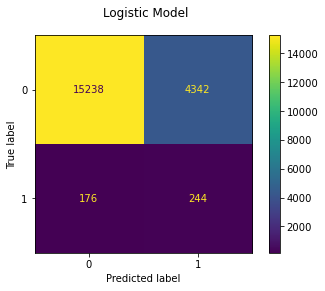

In [14]:
# Confusion matrix for the logistic model
fig, ax = plt.subplots()

fig.suptitle("Logistic Model")

plot_confusion_matrix(grid_log, X_test_proc, y_test, ax=ax, values_format='');

## KNNeighbors Classifier

In [15]:
knnpipe = Pipeline([
    ('knn', KNeighborsClassifier())
])

# Parameters for the grid search
parameters = {
    'knn__n_neighbors': [5], # Tried: 2-10
    'knn__leaf_size': [10, 15, 20, 25] # Tried: 30, 50, 100
}

# Perform grid search prioritizing precision
grid_knn = GridSearchCV(knnpipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_knn.fit(X_train_proc, y_train.values.ravel())

print(grid_knn.best_score_)
print(grid_knn.best_params_)

0.6462462750000001
{'knn__leaf_size': 10, 'knn__n_neighbors': 5}


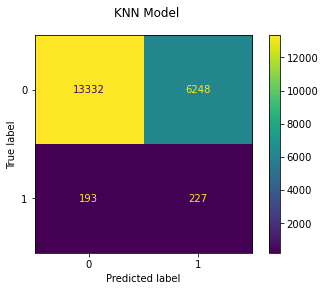

In [16]:
# Confusion matrix for the KNN model
fig, ax = plt.subplots()

fig.suptitle("KNN Model")

plot_confusion_matrix(grid_knn, X_test_proc, y_test, ax=ax, values_format='');

## Decision Tree Classifier

In [17]:
treepipe = Pipeline([
    ('tree', DecisionTreeClassifier())
])

# Parameters for the grid search
parameters = {
    'tree__criterion': ['entropy'], # Tried: gini, log_loss
    'tree__max_depth': [7], # Tried: 2-20
    'tree__min_samples_split': [2], # Tried: 2-50
    'tree__min_samples_leaf': [210], # Tried: 2-300
    'tree__random_state': [27]
}

# Perform grid search prioritizing precision
grid_tree = GridSearchCV(treepipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_tree.fit(X_train_proc, y_train.values.ravel())

print(grid_tree.best_score_)
print(grid_tree.best_params_)

0.7332904499999999
{'tree__criterion': 'entropy', 'tree__max_depth': 7, 'tree__min_samples_leaf': 210, 'tree__min_samples_split': 2, 'tree__random_state': 27}


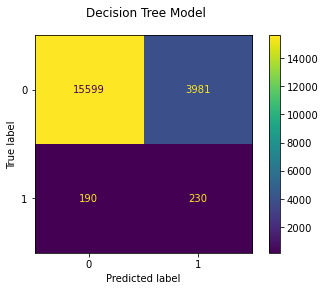

In [18]:
# Confusion matrix for the Tree model
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Model")

plot_confusion_matrix(grid_tree, X_test_proc, y_test, ax=ax, values_format='');

## Random Forest

In [19]:
forestpipe = Pipeline([
    ('forest', RandomForestClassifier())
])

# Parameters for the grid search
parameters = {
    'forest__n_estimators': [245], # Tried: 2-300
    'forest__criterion': ['gini'], # Tried: entropy
    'forest__min_samples_split': [6], # Tried: 2-20
    'forest__max_depth': [15], # Tried: 2-50
    'forest__random_state': [27]
}

# Perform grid search prioritizing precision
grid_forest = GridSearchCV(forestpipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_forest.fit(X_train_proc, y_train.values.ravel())

print(grid_forest.best_score_)
print(grid_forest.best_params_)

0.7506622000000001
{'forest__criterion': 'gini', 'forest__max_depth': 15, 'forest__min_samples_split': 6, 'forest__n_estimators': 245, 'forest__random_state': 27}


## XGBoost

In [20]:
boostpipe = Pipeline([
    ('boost', xgboost.XGBClassifier())
])

# Parameters for grid search
parameters = {
    'boost__max_depth': [2], # Tried: 2-5
    'boost__min_child_weight': [20], # Tried: 1-50
    'boost__gamma': [1], # Tried: 0.5-5
    'boost__n_estimators': [65], # Tried: 5-75
    'boost__random_state': [27]
}

# Grid search with boost model
grid_boost = GridSearchCV(boostpipe, param_grid=parameters, scoring='roc_auc')

# Fit model and generate predictions
grid_boost.fit(X_train_proc, y_train.values.ravel())

print(grid_boost.best_score_)
print(grid_boost.best_params_)

0.7535994500000001
{'boost__gamma': 1, 'boost__max_depth': 2, 'boost__min_child_weight': 20, 'boost__n_estimators': 65, 'boost__random_state': 27}


In [21]:
y_train_boost = grid_boost.predict(X_train_proc)
print(recall_score(y_train, y_train_boost))

y_test_boost = grid_boost.predict(X_test_proc)
print(recall_score(y_test, y_test_boost))

0.5789
0.5666666666666667


In [22]:
dummy_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DummyClassifier(strategy='most_frequent'))]
)

dummy_clf.fit(X_train, y_train)
print("Model score: %.3f" % dummy_clf.score(X_test, y_test))

Model score: 0.979


In [23]:
y_pred_dummy = dummy_clf.predict(X_test)

In [24]:
print(recall_score(y_test, y_pred_dummy))

0.0


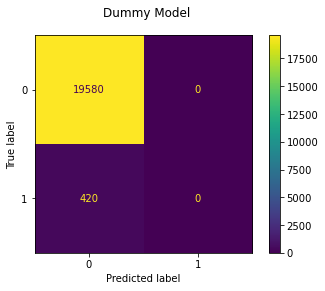

In [25]:
# Confusion matrix for the dummy model
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_clf, X_test, y_test, ax=ax, values_format='');


In [26]:
log_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=27, max_iter=1000))]
)

log_clf.fit(X_train, y_train)
print("Model score: %.3f" % log_clf.score(X_test, y_test))

C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model score: 0.776


Business Metric: Recall

In [27]:
y_pred_log = log_clf.predict(X_test)
print(recall_score(y_test, y_pred_log))

0.5761904761904761


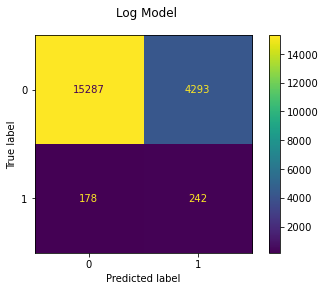

In [28]:
# Confusion matrix for the logistic model
fig, ax = plt.subplots()

fig.suptitle("Log Model")

plot_confusion_matrix(log_clf, X_test, y_test, ax=ax, values_format='');
